# Custom LRP rules
One of the design goals of ExplainableAI.jl is to combine ease of use and
extensibility for the purpose of research.

This example will show you how to implement custom LRP rules.
building on the basics shown in the *Getting started* section.

We start out by loading the same pre-trained LeNet5 model and MNIST input data:

In [1]:
using ExplainableAI
using Flux
using MLDatasets
using ImageCore
using BSON

index = 10
x, y = MNIST(Float32, :test)[10]
input = reshape(x, 28, 28, 1, :)

model = BSON.load("../../model.bson", @__MODULE__)[:model] # hide
model

Chain(
  Conv((5, 5), 1 => 6, relu),           # 156 parameters
  MaxPool((2, 2)),
  Conv((5, 5), 6 => 16, relu),          # 2_416 parameters
  MaxPool((2, 2)),
  Flux.flatten,
  Dense(256 => 120, relu),              # 30_840 parameters
  Dense(120 => 84, relu),               # 10_164 parameters
  Dense(84 => 10),                      # 850 parameters
)                   # Total: 10 arrays, 44_426 parameters, 174.867 KiB.

## Implementing a custom rule
### Step 1: Define rule struct
Let's define a rule that modifies the weights and biases of our layer on the forward pass.
The rule has to be of supertype `AbstractLRPRule`.

In [2]:
struct MyGammaRule <: AbstractLRPRule end

### Step 2: Implement rule behavior
It is then possible to dispatch on the following four utility functions
with the rule type `MyCustomLRPRule` to define custom rules without writing boilerplate code.

1. `modify_input(rule::MyGammaRule, input)`
1. `modify_parameters(rule::MyGammaRule, parameter)`
1. `modify_denominator(rule::MyGammaRule, denominator)`
1. `is_compatible(rule::MyGammaRule, layer)`

By default:
1. `modify_input` doesn't change the input
1. `modify_parameters` doesn't change the parameters
1. `modify_denominator` avoids division by zero by adding a small epsilon-term (`1.0f-9`)
1. `is_compatible` returns `true` if a layer has fields `weight` and `bias`

To extend internal functions, import them explicitly:

In [3]:
import ExplainableAI: modify_parameters

modify_parameters(::MyGammaRule, param) = param + 0.25f0 * relu.(param)

modify_parameters (generic function with 6 methods)

Note that we didn't implement three of the four functions.
This is because the defaults are sufficient to implement the `GammaRule`.

### Step 3: Use rule in LRP analyzer
We can directly use our rule to make an analyzer!

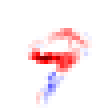

In [4]:
rules = [
    ZPlusRule(),
    EpsilonRule(),
    MyGammaRule(), # our custom GammaRule
    EpsilonRule(),
    ZeroRule(),
    ZeroRule(),
    ZeroRule(),
    ZeroRule(),
]
analyzer = LRP(model, rules)
heatmap(input, analyzer)

We just implemented our own version of the $γ$-rule in 2 lines of code.
The heatmap perfectly matches the pre-implemented `GammaRule`:

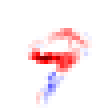

In [5]:
rules = [
    ZPlusRule(),
    EpsilonRule(),
    GammaRule(), # XAI.jl's GammaRule
    EpsilonRule(),
    ZeroRule(),
    ZeroRule(),
    ZeroRule(),
    ZeroRule(),
]
analyzer = LRP(model, rules)
heatmap(input, analyzer)

## Performance tips
1. Make sure functions like `modify_parameters` don't promote the type of weights
   (e.g. from `Float32` to `Float64`).
2. If your rule `MyRule` doesn't modify weights or biases,
   defining `modify_layer(::MyRule, layer) = nothing`
   can provide reduce memory allocations and improve performance.

## Advanced layer modification
For more granular control over weights and biases,
`modify_weight` and
`modify_bias` can be used.

If the layer doesn't use weights (`layer.weight`) and biases (`layer.bias`),
ExplainableAI provides a lower-level variant of
`modify_parameters` called
`modify_layer`.
This function is expected to take a layer and return a new, modified layer.
To add compatibility checks between rule and layer types, extend
`is_compatible`.

## Advanced LRP rules
To implement custom LRP rules that require more than `modify_layer`, `modify_input`
and `modify_denominator`, take a look at the LRP developer documentation.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*